Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Diffusion Models for Medical Anomaly Detection with Classifier Guidance

This tutorial illustrates how to use MONAI for training a 2D gradient-guided anomaly detection using DDIMs [1].

We train a diffusion model on 2D slices of brain MR images. A classification model is trained to predict whether the given slice shows a tumor or not.\
We then translate an input slice to its healthy reconstruction using DDIMs.\
Anomaly detection is performed by taking the difference between input and output, as proposed in [1].

[1] - Wolleb et al. "Diffusion Models for Medical Anomaly Detection" https://arxiv.org/abs/2203.04306

## Setup environment

In [20]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import seaborn" || pip install -q seaborn

## Setup imports

In [2]:
import os
import time
import tempfile
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import set_determinism
from torch.amp import GradScaler, autocast
from tqdm import tqdm

from monai.inferers import DiffusionInferer
from monai.networks.nets.diffusion_model_unet import DiffusionModelEncoder, DiffusionModelUNet
from monai.networks.schedulers.ddim import DDIMScheduler

torch.multiprocessing.set_sharing_strategy("file_system")

print_config()

MONAI version: 1.4.dev2434
Numpy version: 1.26.4
Pytorch version: 2.4.0+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: dc611d231ba670004b1da1b011fe140375fb91af
MONAI __file__: /home/<username>/monaigen-tutorials-v2/venv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.4.0
Tensorboard version: 2.17.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.66.5
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 6.0.0
pandas version: 2.2.2
einops version: 0.8.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or 

## Setup data directory

In [3]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

## Set deterministic training for reproducibility

In [4]:
set_determinism(42)

## Preprocessing of the BRATS Dataset in 2D slices for training
We download the BRATS training dataset from the Decathlon dataset. \
We slice the volumes in axial 2D slices, and assign slice-wise labels (0 for healthy, 1 for diseased) to all slices.
Here we use transforms to augment the training dataset:

1. `LoadImaged` loads the brain MR images from files.
2. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
2. `ScaleIntensityRangePercentilesd` takes the lower and upper intensity percentiles and scales them to [0, 1].
3. The first `Lambdad` transform selects a pre-defined channel, in this case, channel zero, representing the FLAIR images.
4. The `CopyItemsd` transform creates a copy of the label called slice_label
5. The final `Lambdad` transform sets the slice_label variable to one if there are no non-zero pixels in it, and zero otherwise.


In [6]:
channel = 0  # 0 = Flair
assert channel in [0, 1, 2, 3], "Choose a valid channel"

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        transforms.Lambdad(keys=["image"], func=lambda x: x[channel, :, :, :]),
        transforms.EnsureChannelFirstd(keys=["image"], channel_dim="no_channel"),
        transforms.EnsureTyped(keys=["image", "label"]),
        transforms.Orientationd(keys=["image", "label"], axcodes="RAS"),
        transforms.Spacingd(keys=["image", "label"], pixdim=(3.0, 3.0, 2.0), mode=("bilinear", "nearest")),
        transforms.CenterSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 44)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower=0, upper=99.5, b_min=0, b_max=1),
        transforms.RandSpatialCropd(keys=["image", "label"], roi_size=(64, 64, 1), random_size=False),
        transforms.Lambdad(keys=["image", "label"], func=lambda x: x.squeeze(-1)),
        transforms.CopyItemsd(keys=["label"], times=1, names=["slice_label"]),
        transforms.Lambdad(keys=["slice_label"], func=lambda x: 0.0 if x.sum() > 0 else 1.0),
    ]
)

In [8]:
batch_size = 64

train_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="training",  # validation
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasn't been downloaded yet
    seed=0,
    transform=train_transforms,
)

print(f"Length of training data: {len(train_ds)}")  # this gives the number of patients in the training set
print(f'Train image shape {train_ds[0]["image"].shape}')

train_loader = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True, persistent_workers=True
)

Task01_BrainTumour.tar: 7.09GB [15:16, 8.30MB/s]                                

2024-09-10 18:43:27,806 - INFO - Downloaded: /tmp/tmp_1zmh1hd/Task01_BrainTumour.tar


2024-09-10 18:43:41,662 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-09-10 18:43:41,663 - INFO - Writing into directory: /tmp/tmp_1zmh1hd.


Loading dataset: 100%|██████████| 388/388 [05:10<00:00,  1.25it/s]

Length of training data: 388
Train image shape torch.Size([1, 64, 64])


## Preprocessing of the BRATS Dataset in 2D slices for validation
We download the BRATS validation dataset from the Decathlon dataset, and define the dataloader to load 2D slices for validation.



In [9]:
val_ds = DecathlonDataset(
    root_dir=root_dir,
    task="Task01_BrainTumour",
    section="validation",
    cache_rate=1.0,  # you may need a few Gb of RAM... Set to 0 otherwise
    num_workers=4,
    download=True,  # Set download to True if the dataset hasn't been downloaded yet
    seed=0,
    transform=train_transforms,
)
print(f"Length of training data: {len(val_ds)}")
print(f'Validation Image shape {val_ds[0]["image"].shape}')

val_loader = DataLoader(
    val_ds, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True, persistent_workers=True
)

2024-09-11 15:14:45,612 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-09-11 15:14:45,614 - INFO - File exists: /tmp/tmp_1zmh1hd/Task01_BrainTumour.tar, skipped downloading.
2024-09-11 15:14:45,615 - INFO - Non-empty folder exists in /tmp/tmp_1zmh1hd/Task01_BrainTumour, skipped extracting.


Loading dataset: 100%|██████████| 96/96 [01:23<00:00,  1.15it/s]

Length of training data: 96
Validation Image shape torch.Size([1, 64, 64])


## Define network, scheduler, optimizer, and inferer
At this step, we instantiate the MONAI components to create a DDIM, the UNET, the noise scheduler, and the inferer used for training and sampling. We are using
the deterministic DDIM scheduler containing 1000 timesteps, and a 2D UNET with attention mechanisms
in the 3rd level (`num_head_channels=64`).


In [10]:
device = torch.device("cuda")

model = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(64, 64, 64),
    attention_levels=(False, False, True),
    num_res_blocks=1,
    num_head_channels=64,
    with_conditioning=False,
)
model.to(device)

scheduler = DDIMScheduler(num_train_timesteps=1000)

optimizer = torch.optim.Adam(params=model.parameters(), lr=2.5e-5)

inferer = DiffusionInferer(scheduler)

## Model training of the diffusion model
We train our diffusion model for 2000 epochs.

Epoch 0 Validation loss 0.49252671003341675
Epoch 20 Validation loss 0.22828049957752228
Epoch 40 Validation loss 0.08093317598104477
Epoch 60 Validation loss 0.03429413586854935

Epoch 1960 Validation loss 0.013749875128269196
Epoch 1980 Validation loss 0.007845446467399597
train diffusion completed, total time: 2144.4541273117065.


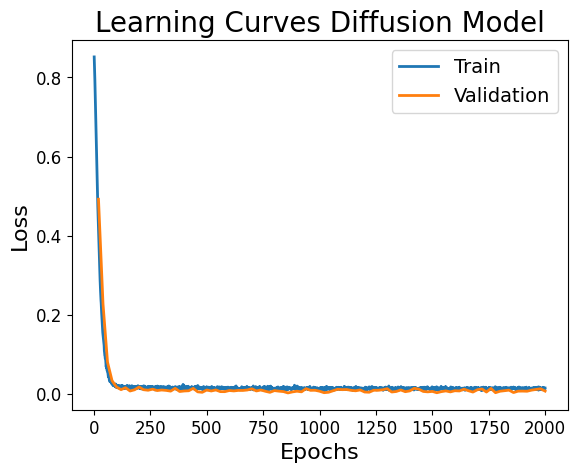

In [11]:
max_epochs = 2000
val_interval = 20
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler("cuda")
total_start = time.time()

for epoch in range(max_epochs):
    model.train()
    len_train_loader = len(train_loader)
    epoch_loss = 0

    for data in train_loader:
        images = data["image"].to(device)
        classes = data["slice_label"].to(device)
        optimizer.zero_grad(set_to_none=True)
        timesteps = torch.randint(0, 1000, (len(images),)).to(device)  # pick a random timestep

        with autocast(enabled=True, device_type="cuda"):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    epoch_loss_list.append(epoch_loss / (len_train_loader + 1))

    if epoch % val_interval == 0:
        model.eval()
        len_val_loader = len(val_loader)
        val_epoch_loss = 0

        for data in val_loader:
            images = data["image"].to(device)
            classes = data["slice_label"].to(device)
            timesteps = torch.randint(0, 1000, (len(images),)).to(device)
            with torch.no_grad():
                with autocast(enabled=True, device_type="cuda"):
                    noise = torch.randn_like(images).to(device)
                    noise_pred = inferer(inputs=images, diffusion_model=model, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
        val_epoch_loss_list.append(val_epoch_loss / (len_val_loader + 1))
        print("Epoch", epoch, "Validation loss", val_epoch_loss / (len_val_loader + 1))

total_time = time.time() - total_start
print(f"train diffusion completed, total time: {total_time}.")

plt.style.use("default")
plt.title("Learning Curves Diffusion Model", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

## Check the performance of the diffusion model

We generate a random image from noise to check whether our diffusion model works properly for an image generation task.



100%|██████████| 1000/1000 [00:17<00:00, 56.32it/s]


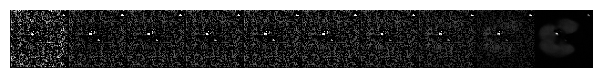

In [12]:
model.eval()
noise = torch.randn((1, 1, 64, 64))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
with autocast(enabled=True, device_type="cuda"):
    image, intermediates = inferer.sample(
        input_noise=noise, diffusion_model=model, scheduler=scheduler, save_intermediates=True, intermediate_steps=100
    )

chain = torch.cat(intermediates, dim=-1)

plt.style.use("default")
plt.imshow(chain[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

## Define the classification model
First, we define the classification model. It follows the encoder architecture of the diffusion model, combined with linear layers for binary classification between healthy and diseased slices.


In [13]:
device = torch.device("cuda")
classifier = DiffusionModelEncoder(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(32, 64, 64),
    attention_levels=(False, True, True),
    num_res_blocks=(1, 1, 1),
    num_head_channels=64,
    with_conditioning=False,
)

classifier.to(device)

DiffusionModelEncoder(
  (conv_in): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): DiffusionUNetResnetBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Diffusion

## Model training of the classification model
We train our classification model for 1000 epochs.


Epoch 9 Validation loss 0.27587130665779114
Epoch 19 Validation loss 0.23130261898040771
Epoch 29 Validation loss 0.15939612686634064

Epoch 989 Validation loss 0.10873827338218689
Epoch 999 Validation loss 0.15586623549461365
train completed, total time: 774.1744227409363.


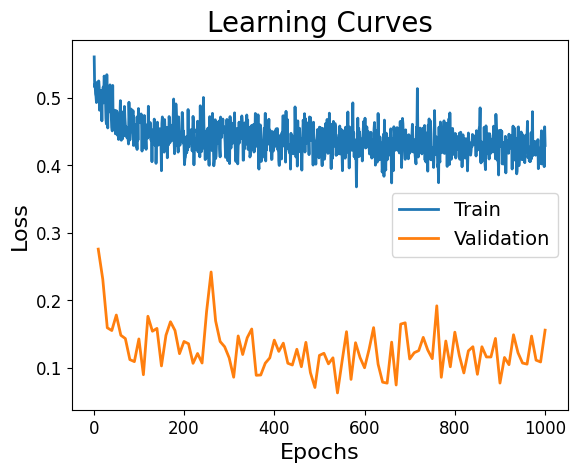

In [14]:
max_epochs = 1000
val_interval = 10
epoch_loss_list = []
val_epoch_loss_list = []
optimizer_cls = torch.optim.Adam(params=classifier.parameters(), lr=2.5e-5)


scaler = GradScaler("cuda")
total_start = time.time()
for epoch in range(max_epochs):
    classifier.train()
    len_train_loader = len(train_loader)
    epoch_loss = 0

    for data in train_loader:
        images = data["image"].to(device)
        classes = data["slice_label"].to(device)

        optimizer_cls.zero_grad(set_to_none=True)
        timesteps = torch.randint(0, 1000, (len(images),)).to(device)

        with autocast(enabled=False, device_type="cuda"):
            # Generate random noise
            noise = torch.randn_like(images).to(device)

            # Get model prediction
            noisy_img = scheduler.add_noise(images, noise, timesteps)  # add t steps of noise to the input image
            pred = classifier(noisy_img, timesteps)

            loss = F.cross_entropy(pred, classes.long())

            loss.backward()
            optimizer_cls.step()

        epoch_loss += loss.item()
    epoch_loss_list.append(epoch_loss / (len_train_loader + 1))

    if (epoch + 1) % val_interval == 0:
        classifier.eval()
        len_val_loader = len(val_loader)
        val_epoch_loss = 0

        for data_val in val_loader:
            images = data_val["image"].to(device)
            classes = data_val["slice_label"].to(device)
            timesteps = torch.randint(0, 1, (len(images),)).to(
                device
            )  # check validation accuracy on the original images, i.e., do not add noise

            with torch.no_grad():
                with autocast(enabled=False, device_type="cuda"):
                    noise = torch.randn_like(images).to(device)
                    pred = classifier(images, timesteps)
                    val_loss = F.cross_entropy(pred, classes.long(), reduction="mean")

            val_epoch_loss += val_loss.item()
            _, predicted = torch.max(pred, 1)
            val_epoch_loss_list.append(val_epoch_loss / (len_val_loader + 1))
        print("Epoch", epoch, "Validation loss", val_epoch_loss / (len_val_loader + 1))

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

# Learning curves for the Classifier

plt.style.use("default")
plt.title("Learning Curves", fontsize=20)
plt.plot(np.linspace(1, max_epochs, max_epochs), epoch_loss_list, color="C0", linewidth=2.0, label="Train")
plt.plot(
    np.linspace(val_interval, max_epochs, int(max_epochs / val_interval)),
    val_epoch_loss_list,
    color="C1",
    linewidth=2.0,
    label="Validation",
)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.legend(prop={"size": 14})
plt.show()

# Image-to-image translation to a healthy subject
We pick a diseased subject of the validation set as input image. We want to translate it to its healthy reconstruction.

minmax metatensor(0.) metatensor(0.8833)


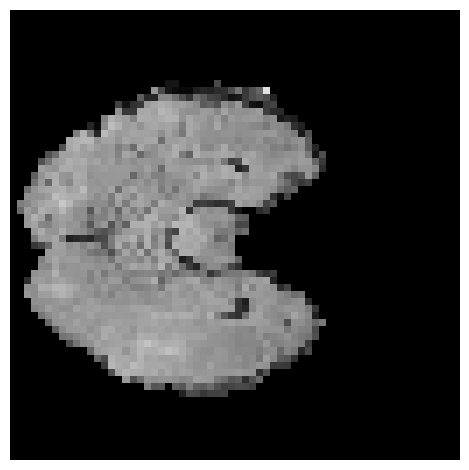

DiffusionModelEncoder(
  (conv_in): Convolution(
    (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock(
      (resnets): ModuleList(
        (0): DiffusionUNetResnetBlock(
          (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
          (nonlinearity): SiLU()
          (conv1): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
          (conv2): Convolution(
            (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
          (skip_connection): Identity()
        )
      )
      (downsampler): Diffusion

In [15]:
idx_unhealthy = np.argwhere(data_val["slice_label"].numpy() == 0).squeeze()
idx = idx_unhealthy[4]  # Pick a random slice of the validation set to be transformed
inputimg = data_val["image"][idx]  # Pick an input slice of the validation set to be transformed
inputlabel = data_val["slice_label"][idx]  # Check whether it is healthy or diseased
print("minmax", inputimg.min(), inputimg.max())

plt.figure("input" + str(inputlabel))
plt.imshow(inputimg[0, ...], vmin=0, vmax=1, cmap="gray")
plt.axis("off")
plt.tight_layout()
plt.show()

model.eval()
classifier.eval()

### Encoding the input image in noise with the reversed DDIM sampling scheme
In order to sample using gradient guidance, we first need to encode the input image in noise by using the reversed DDIM sampling scheme.\
We define the number of steps in the noising and denoising process by L.\
The encoding process is presented in Equation 6 of the paper "Diffusion Models for Medical Anomaly Detection" (https://arxiv.org/pdf/2203.04306.pdf).


100%|██████████| 200/200 [00:05<00:00, 37.53it/s]


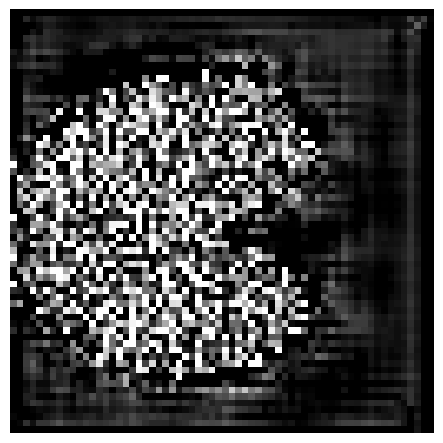

In [16]:
L = 200
current_img = inputimg[None, ...].to(device)
scheduler.set_timesteps(num_inference_steps=1000)

progress_bar = tqdm(range(L))  # go back and forth L timesteps
for t in progress_bar:  # go through the noising process
    with autocast(enabled=False, device_type="cuda"):
        with torch.no_grad():
            model_output = model(current_img, timesteps=torch.Tensor((t,)).to(current_img.device))
    current_img, _ = scheduler.reversed_step(model_output, t, current_img)

plt.style.use("default")
plt.imshow(current_img[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

### Denoising process using gradient guidance
From the noisy image, we apply DDIM sampling scheme for denoising for L steps.\
Additionally, we apply gradient guidance using the classifier network towards the desired class label y=0 (healthy). This is presented in Algorithm 2 of https://arxiv.org/pdf/2105.05233.pdf, and in Algorithm 1 of https://arxiv.org/pdf/2203.04306.pdf. \
The scale s is used to amplify the gradient.

100%|██████████| 200/200 [00:12<00:00, 15.77it/s]


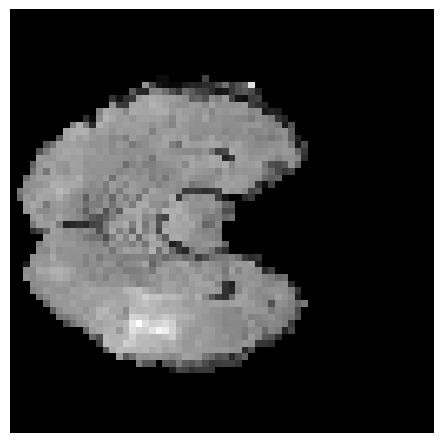

In [17]:
y = torch.tensor(0)  # define the desired class label
scale = 6  # define the desired gradient scale s
progress_bar = tqdm(range(L))  # go back and forth L timesteps

for i in progress_bar:  # go through the denoising process
    t = L - i
    with autocast(enabled=True, device_type="cuda"):
        with torch.no_grad():
            model_output = model(
                current_img, timesteps=torch.Tensor((t,)).to(current_img.device)
            ).detach()  # this is supposed to be epsilon

        with torch.enable_grad():
            x_in = current_img.detach().requires_grad_(True)
            logits = classifier(x_in, timesteps=torch.Tensor((t,)).to(current_img.device))
            log_probs = F.log_softmax(logits, dim=-1)
            selected = log_probs[range(len(logits)), y.view(-1)]
            a = torch.autograd.grad(selected.sum(), x_in)[0]
            alpha_prod_t = scheduler.alphas_cumprod[t]
            updated_noise = (
                model_output - (1 - alpha_prod_t).sqrt() * scale * a
            )  # update the predicted noise epsilon with the gradient of the classifier

    current_img, _ = scheduler.step(updated_noise, t, current_img)
    torch.cuda.empty_cache()

plt.style.use("default")
plt.imshow(current_img[0, 0].cpu().detach().numpy(), vmin=0, vmax=1, cmap="gray")
plt.tight_layout()
plt.axis("off")
plt.show()

# Anomaly Detection
To get the anomaly map, we compute the difference between the input image the output of our image-to-image translation model towards the healthy reconstruction.

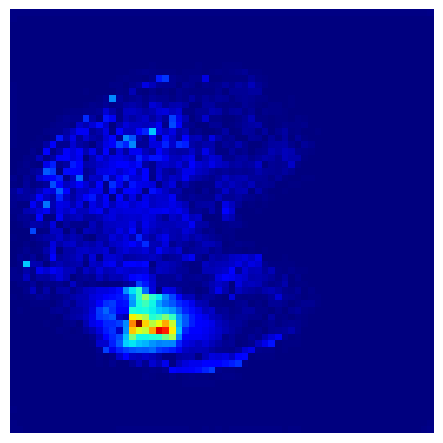

In [18]:
diff = abs(inputimg.cpu() - current_img[0, 0].cpu()).detach().numpy()
plt.style.use("default")
plt.imshow(diff[0, ...], cmap="jet")
plt.tight_layout()
plt.axis("off")
plt.show()